Домашнее задание по результатам 4 вебинара.

Как было сказано ранее, GAN обучается воспроизводить реальные данные. Поэтому Вам предлагается обучить генератор создавать точки, которые будут лежать на графике функции 
$$y=\frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Без графиков домашку не принимаю


## 0. Подготовка
Подключаем нужные модули и библиотеки

In [1]:
import os
import numpy as np
import math

from torch.utils.data import DataLoader, TensorDataset
import torchvision.transforms as transforms
from torchvision import datasets
from torch.autograd import Variable

import torch.nn as nn
import torch

########### Вывод изображений и их сохранение
import matplotlib.pyplot as plt
from IPython import display
from torchvision.utils import save_image, make_grid

Определим нужное нам устройство:

In [2]:
use_cuda = torch.cuda.is_available()
# device = torch.device("cpu")
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


### 1. Загрузка датасета

In [3]:
dot_size = (1,2) # размер картинки которую мы будет подавать в нейронные сети
channels = 1 # количество каналов в нашей картинке
batch_size = 100 # размер батча
data_shape = (channels, dot_size[0], dot_size[1]) # полный шейп нашей картинки

Встроенными возможностями загружаем датасет [MNIST](http://yann.lecun.com/exdb/mnist/):

In [4]:
def formula(x):
    return np.sin(x)/x - x/10

In [5]:
# def formula(x):
#     return 2*np.sin(5*x)

In [6]:
# def create_dataset1(size:int):
#     x_true = np.random.random_sample(size//2)
#     y_true = np.array([[i, formula(i)] for i in x_true], dtype='float32')
#     y_false = np.random.random_sample((size//2, 2))
#     features = np.concatenate((y_true, y_false))
#     lables = [1 if i < size//2 else 0 for i in range(size)]
#     return features , lables

In [7]:
def create_dataset(size:int,x_size=10, bias=5):
    x_true = np.random.random_sample(size) * x_size - bias
    features = np.array([[i, formula(i)] for i in x_true], dtype='float32')
    lables = np.ones(size)
    return features , lables

In [8]:
train, lables = create_dataset(10000)

In [9]:
train = TensorDataset(torch.Tensor(train), torch.Tensor(lables))
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)

tensor([[-1.9722,  0.6640],
        [ 2.8762, -0.1964],
        [-2.3085,  0.5514],
        [ 0.3515,  0.9444],
        [ 1.9422,  0.2856]]) tensor([1., 1., 1., 1., 1.])


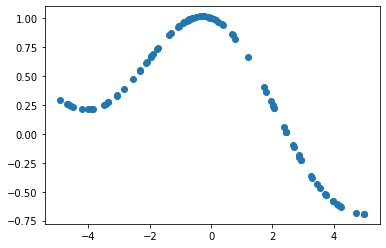

In [10]:
dataiter = iter(train_loader)
dot, labels = dataiter.next()
print(dot[:5], labels[:5])
plt.scatter(dot[:,0],dot[:,1])

Вытащим часть сэмпла и посмотри что внутри:

### 2. Создание модели

#### 2.1 Генератор:

Генератор G предназначен для отображения вектора скрытого пространства (z) в пространство данных. Поскольку наши данные являются изображениями, преобразование z в пространство данных в конечном итоге означает создание изображения того же размера, что и обучающие изображения (то есть 1x28x28).

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
                ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
                ['relu', nn.ReLU(0.2)]])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'): #activation='relu
            layers = [nn.Linear(in_feat, out_feat)] # Если мы создаем последовательность слоев - то мы задаем их
                                                    # с помощью списка.
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(self.activations[activation]) # Эта сторчка означает тоже самое что и
                                                       # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=True), # Звездочка означает unpacking списка
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(data_shape))),
            nn.LeakyReLU(0.2)
        )
        # 2

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *data_shape)
        return img


#### ... Небольшое отступление 
Создание своих слоев. Если все правильно оформить, то созданный кастомный слой можно будет использовать внутри pytorch как обычный слой.

In [13]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights) # Обьявляем веса кка параметры слоя

        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        nn.init.uniform_(self.weights, -0.005, 0.005) 
        nn.init.uniform_(self.bias, -0.005, 0.005)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные на трнспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  

nn.init.uniform_ Позволяет нам задать значения с помощью нормального распределения

#### nn.init
https://pytorch.org/docs/stable/nn.init.html

#### 2.2 Дискриминатор:

Как уже упоминалось, дискриминатор D представляет собой сеть двоичной классификации, который принимает изображение в качестве входных данных и выводит скалярную вероятность того, что входное изображение является реальным (в отличие от фальшивого). Здесь D принимает входное изображение размером 1x28x28

In [14]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            CustomLinearLayer(int(np.prod(data_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        validity = self.model(img_flat)

        return validity

# 3. Обучение

Инициализация:

In [15]:
n_epochs = 105 # количество эпох
lr = 0.005 # шаг обучения

b1 = 0.5 # гиперпараметр для оптимайзера Adam
b2 = 0.999 # гиперпараметр для оптимайзера Adam

latent_dim = 100 # Размерность случайного вектора, который подается на вход генератору


sample_interval = 10 # количество картинок для отображения процесса обучения

In [16]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

In [17]:
d_loss_history = []
g_loss_history = []

Процесс обучения:

[Epoch 0/105] [Batch 0/100] [D loss: 0.693148] [G loss: 0.694046]


<Figure size 432x288 with 0 Axes>

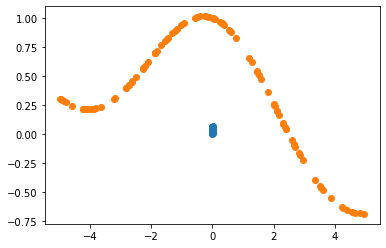

[Epoch 0/105] [Batch 20/100] [D loss: 0.649089] [G loss: 1.119464]


<Figure size 432x288 with 0 Axes>

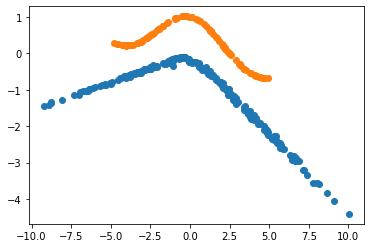

[Epoch 0/105] [Batch 40/100] [D loss: 0.940061] [G loss: 0.474815]


<Figure size 432x288 with 0 Axes>

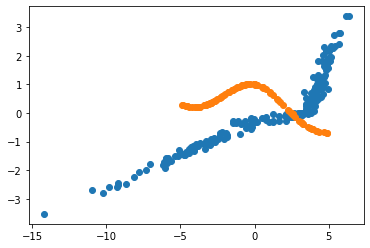

[Epoch 0/105] [Batch 80/100] [D loss: 0.471667] [G loss: 1.091753]


<Figure size 432x288 with 0 Axes>

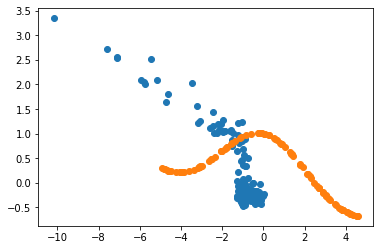

[Epoch 1/105] [Batch 60/100] [D loss: 0.559480] [G loss: 1.178758]


<Figure size 432x288 with 0 Axes>

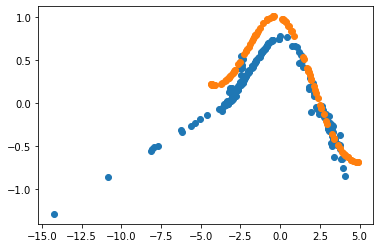

[Epoch 3/105] [Batch 20/100] [D loss: 0.776453] [G loss: 0.706195]


<Figure size 432x288 with 0 Axes>

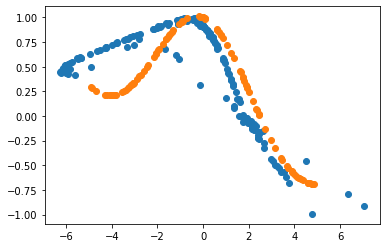

[Epoch 6/105] [Batch 40/100] [D loss: 0.502750] [G loss: 1.579731]


<Figure size 432x288 with 0 Axes>

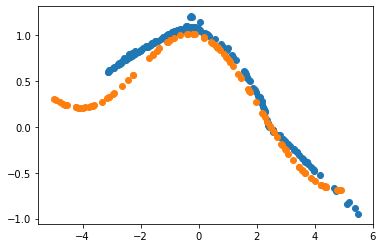

[Epoch 12/105] [Batch 80/100] [D loss: 0.628458] [G loss: 0.900063]


<Figure size 432x288 with 0 Axes>

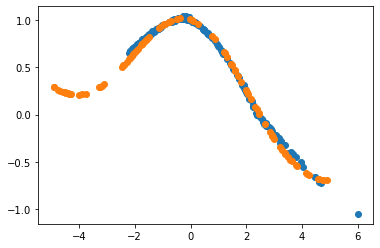

[Epoch 25/105] [Batch 60/100] [D loss: 0.551860] [G loss: 1.121049]


<Figure size 432x288 with 0 Axes>

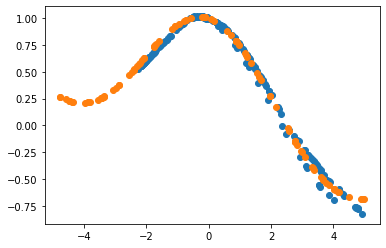

[Epoch 51/105] [Batch 20/100] [D loss: 0.589296] [G loss: 0.789668]


<Figure size 432x288 with 0 Axes>

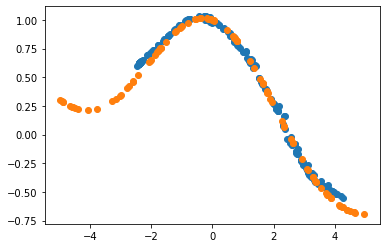

[Epoch 102/105] [Batch 40/100] [D loss: 0.698444] [G loss: 0.824670]


<Figure size 432x288 with 0 Axes>

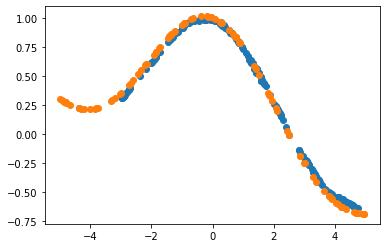

In [18]:
import matplotlib.patches as mpatches

red_patch = mpatches.Patch(color='red', label='D loss')
green_patch = mpatches.Patch(color='green', label='G loss')


for epoch in range(n_epochs):
    for i, (imgs, labels) in enumerate(train_loader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_imgs = imgs.type(torch.FloatTensor).to(device)


######################  Тренировка генератора    ##########################

        optimizer_G.zero_grad()
        #генерация шума
        z = torch.FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем даные Генератором на основе шума
        gen_imgs = generator(z)
        
        # Подаем сгенерированые данные на Дискриминатор 
        validity = discriminator(gen_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(validity, valid)
        
        # Делаем шаг обучения нашего Генератора
        g_loss.backward()
        optimizer_G.step()

######################  Тренировка дискриминатора    ##########################

        optimizer_D.zero_grad()
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_imgs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Опять делаем предсказание на Дискриминаторе с помощью сгенерированных данных
        fake_pred = discriminator(gen_imgs.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(train_loader) + i

        if batches_done % sample_interval == 0:
            with torch.no_grad():
                sample_interval *= 2
                plt.clf()

                # display.clear_output(wait=False)
                # sample_image(gen_imgs)
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(train_loader), d_loss.item(), g_loss.item()) ) 


                display.display(plt.gcf())

                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                z1 = torch.FloatTensor(np.random.normal(0, 1, (200, latent_dim))).to(device)
                gen_imgs = generator(z1).cpu().detach().numpy()
                gen_imgs= gen_imgs.reshape(-1,2)
                plt.scatter(gen_imgs[:,0],gen_imgs[:,1],label = 'Generator')
                dataiter = iter(train_loader)
                dot, labels = dataiter.next()
                plt.scatter(dot[:,0],dot[:,1],label = 'True')
                plt.show()

                # plt.plot(np.log(np.array(d_loss_history)), label='D loss', color = 'red')
                # plt.plot(np.log(np.array(g_loss_history)), label='G loss', color = 'green')
                # plt.legend(handles=[red_patch, green_patch])
                # plt.show()

            

Оранжевый исходный график, синий предсказаный генератором.